# Summary
In the previous notebook (*1_initial_eda.ipynb*) we discobereed several relations between our variables.

In this notebook we will process the data to generate new features and variables:
+ Generated values from combinations of x, y, z
+ Categorical variables transformed to numerical (transtormations defined in each section)
+ Optimization process was defined to stimate the crown, girdle, and pavilion heights

# Modules

In [1]:
import os

import numpy as np
import pandas as pd
from scipy.optimize import LinearConstraint, minimize
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

# Working directory
We set the working directory to the project folder (currently is in the notebooks folder)

In [2]:
current_directory = os.getcwd()
if os.path.basename(current_directory) == 'notebooks':
    os.chdir('./..')

# Data import

In [3]:
all_data = pd.read_parquet('./data/all_data.parquet')
variable_descriptions = pd.read_excel('./data/original_data/Data Dictionary.xlsx', index_col='Variable Name')

In [4]:
for var, desc in variable_descriptions.iterrows():
    print(f'+ {var}: {desc.iloc[0]}')

+ Carat:  Carat weight of the cubic zirconia.
+ Cut:  Describe the cut quality of the cubic zirconia. Quality is increasing order Fair, Good, Very Good, Premium, Ideal.
+ Color :  Colour of the cubic zirconia.With D being the best and J the worst.
+ Clarity:  cubic zirconia Clarity refers to the absence of the Inclusions and Blemishes. (In order from Best to Worst, FL = flawless, I3= level 3 inclusions) FL, IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3
+ Depth:  The Height of a cubic zirconia, measured from the Culet to the table, divided by its average Girdle Diameter.
+ Table:  The Width of the cubic zirconia's Table expressed as a Percentage of its Average Diameter.
+ Price:  the Price of the cubic zirconia.
+ X:  Length of the cubic zirconia in mm.
+ Y:  Width of the cubic zirconia in mm.
+ Z:  Height of the cubic zirconia in mm.


# x, y, z derivated variables

For these variables, we will get:
+ Aspect ratio x vs y ($\frac{min(x, y)}{max(x, y)}$)
+ Total volume ($x \times y \times z$)
+ Lenght of the diagonal cube ($\sqrt{x^2 + y^2 + z^2}$)
+ Table dimensions from x, y and table% as ($x_{table}=x*table \%$, $y_{table}=y*table \%$)

In [5]:
all_data['aspect_ratio'] = all_data[['new_x', 'new_y']].min(axis=1)/all_data[['new_x', 'new_y']].max(axis=1)
all_data['cubic_volume'] = all_data[['new_x', 'new_y', 'new_z']].prod(axis=1)
all_data['diagonal_length'] = (all_data['new_x'].pow(2) + all_data['new_y'].pow(2) + all_data['new_z'].pow(2)).apply(np.sqrt)
all_data['table_x'] = all_data['new_x']*all_data['table']/100
all_data['table_y'] = all_data['new_y']*all_data['table']/100

# Depth and Table perfections

We define two new variables which indicates if the Depth and the Table are in the perfection ranges $[59, 62.6]$ and $[54, 57]$ respectively.

Source: https://www.diamonds.pro/education/triple-excellent-diamond/

In [6]:
all_data['perfect_depth'] = ((all_data['new_depth'] >= 59) & (all_data['new_depth'] <= 62.6))*1
all_data['perfect_table'] = ((all_data['table'] >= 54) & (all_data['table'] <= 57))*1

# Cut

We have 5 categories for the CZ cuts, which are *Fair, Good, Very Good, Premium, Ideal* in increased level of quality. So, we will transform this variable to numerical, with range from 1 to 5 where 1 is *Fair* and 5 is *Ideal*, giving to our data the five levels of cuts.

In [7]:
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
mapping_dict = dict(zip(cut_order, np.arange(1, len(cut_order) + 1)))
all_data['cut_num'] = all_data['cut'].map(mapping_dict)

# Clarity
For this variable we have the next categories
+ IF - Internally Flawless
+ VVS1 - Very Very Slightly Included 1
+ VVS2 - Very Very Slightly Included 2
+ VS1 - Very Slightly Included 1
+ VS2 - Very Slightly Included 2
+ SI1 - Slightly Included 1
+ SI2 - Slightly Included 2
+ I1 - Included 1

So, we will split these values in three variables
+ Var 1: if the value belongs to [IF, VVS, VS, SI, I]
+ Var 2: if the possition of the imperfection is in the border (last digict is 1)
+ Var 3: if the possition of the imperfection is in the center (last digict is 2)

For IF, var 2 and var 3 will be both 0, and for I, it only will take value in var 2.

As the orther matters in this case, we will transform var 1 to a numerical value from 5 to 1 for each class [IF, VVS, VS, SI, I] (5 the best, 1 the worst)

Source: https://www.u7jewelry.com/blogs/jewelry-guide/czcubic-zirconia-vs-diamond

In [8]:
# Only the letters
all_data['clarity_code'] = all_data['clarity'].str.replace(r'\d', '', regex=True)
# Only the numbers
all_data['clarity_number'] = all_data['clarity'].str.replace(r'[^\d]', '', regex=True)
# If the clarity has id 1 2 or none (dual 0)
all_data['clarity_pos1'] = (all_data['clarity_number'] == '1')*1
all_data['clarity_pos2'] = (all_data['clarity_number'] == '2')*1

In [9]:
clarity_order = ['I', 'SI', 'VS', 'VVS', 'IF']
mapping_dict = dict(zip(clarity_order, np.arange(1, len(clarity_order) + 1)))
all_data['clarity_code_num'] = all_data['clarity_code'].map(mapping_dict)

# Color

We have 7 kinds of colors, from D to J, which indicates the quality of the gem color. A J color is worse than a D color, so we will map the values D-J to the numbers 7-1, where 7 is D and 1 is J

Also, we will define a new binary var which will indicate if the color belongs to $[D, E, F]$ or not. This feature is derived from the color scale defined ahead, where $[D, E, F]$ are assigned to *colorless* and $[G, H, I, J]$ are asigned to *near colorless*


![color_scale](https://4cs.gia.edu/wp-content/uploads/2013/03/diamond-color.jpg)

Source: https://4cs.gia.edu/en-us/blog/diamond-color-chart-official-gia-color-scale/

In [10]:
color_order = np.sort(all_data['color'].unique())
mapping_dict = dict(zip(color_order, np.arange(len(color_order), 0, -1)))
all_data['color_num'] = all_data['color'].map(mapping_dict)

In [11]:
all_data['colorless'] = all_data['color'].isin(['D', 'E', 'F'])*1

# Gem volume from Carat

From carat we can infer the volume of the gem, using the Cubic Zirconia density of $5.65 g/cm^3$ and the formula
$$ Density = \frac{Mass}{Volume} \rightarrow Volume = \frac{Mass}{Density}$$
We can obtain the volume of the gem. Where we need to change the carat mass unit to grams ($1 \, carat = 0.2 \, grams$).

Sources:
1. https://www.imetra.com/cubic-zirconia-material-properties/
2. https://en.wikipedia.org/wiki/Density

In [12]:
cz_density = 5.65
all_data['gem_volume'] = (all_data['carat']*0.2)/cz_density

# New features correlations

In [13]:
new_features = ['price', 'carat', 'aspect_ratio', 'cubic_volume', 'diagonal_length',
                'table_x', 'table_y', 'cut_num', 'clarity_code_num', 'clarity_pos1',
                'clarity_pos2', 'color_num', 'colorless', 'gem_volume']

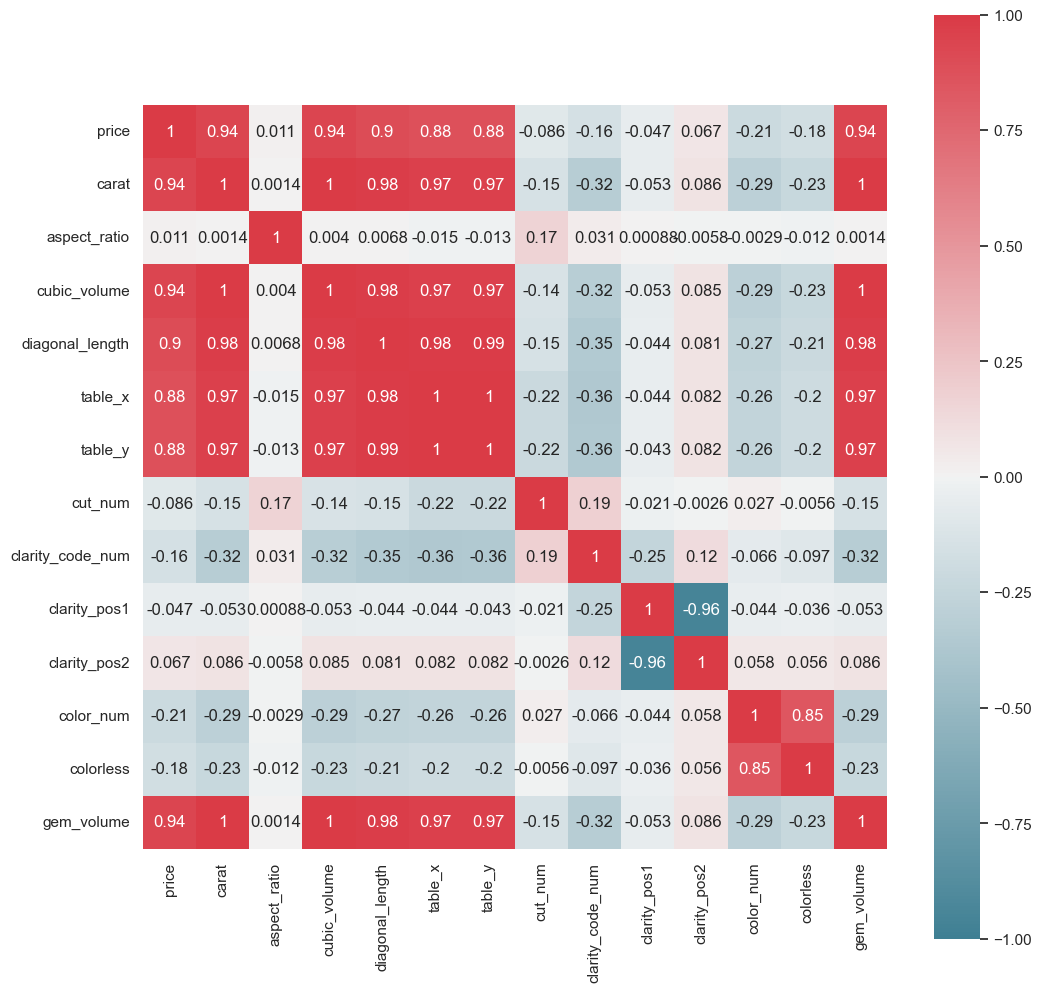

In [14]:
plt.figure(figsize=(12, 12))
sns.heatmap(all_data[new_features].corr(),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, annot=True)
plt.show()

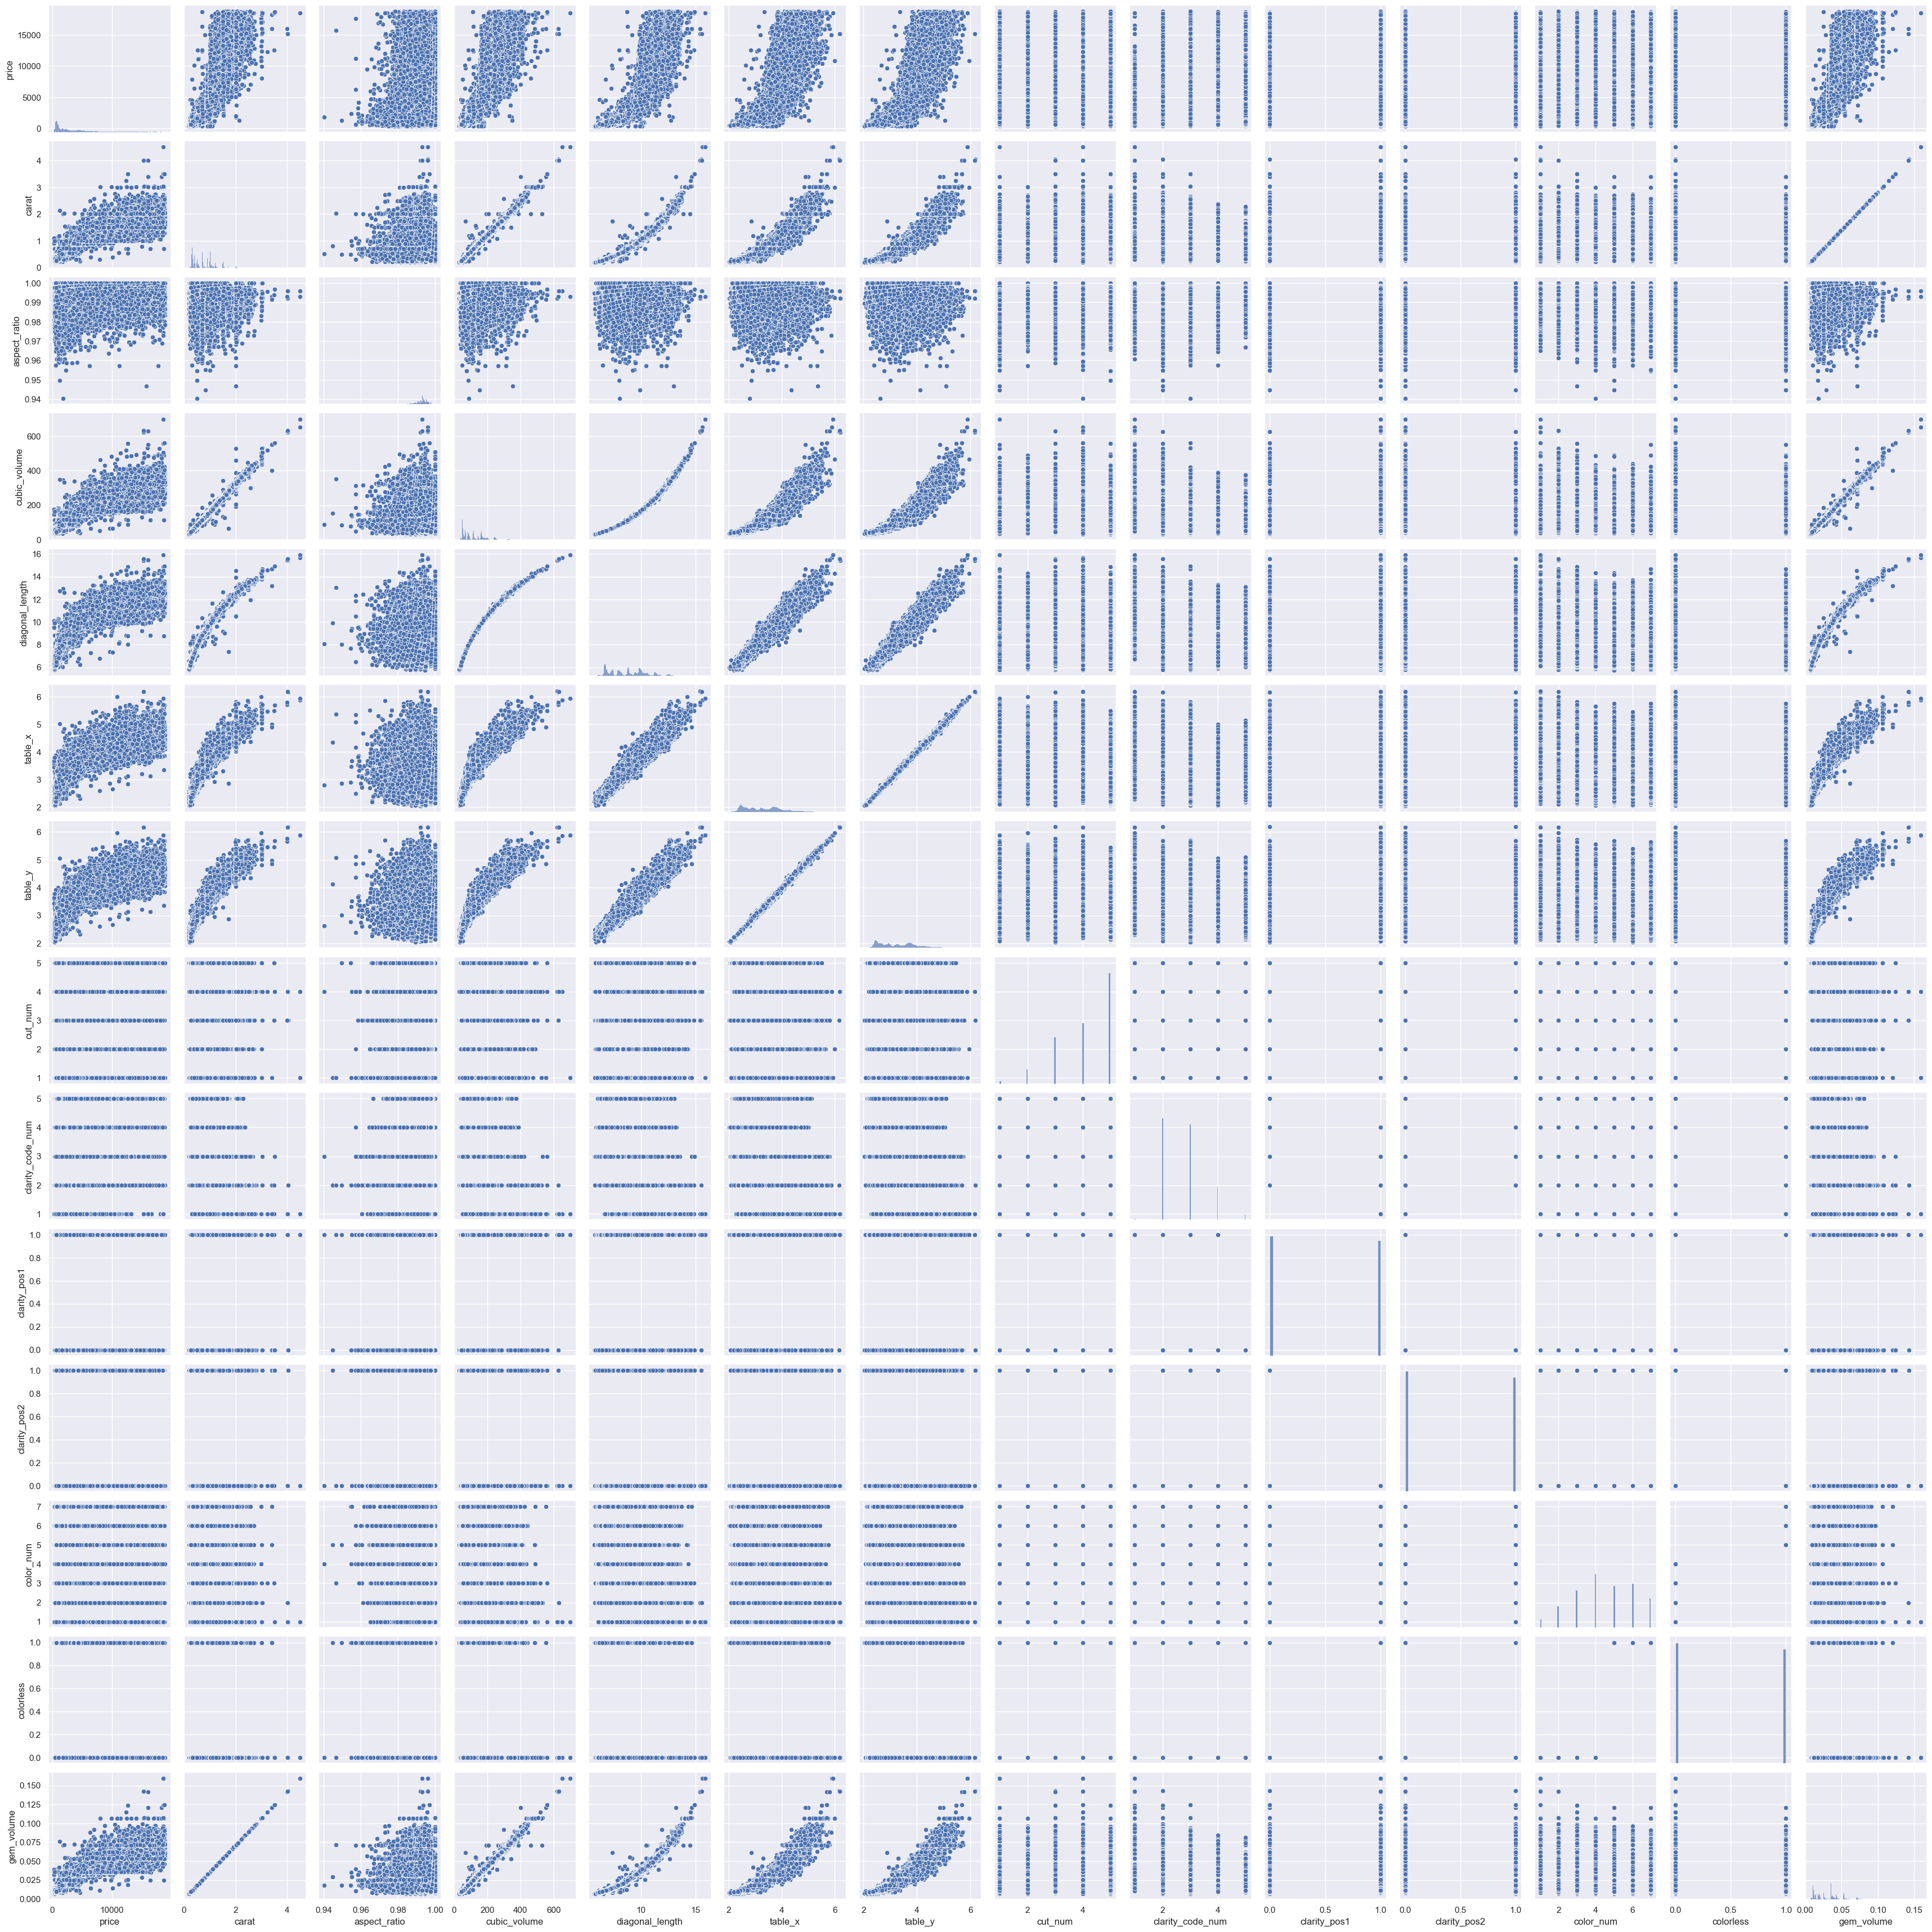

In [15]:
sns.pairplot(data=all_data[new_features])

# Crown an pavilion depths

Given the next gem structure

![diamond_parts](https://www.everything-wedding-rings.com/images/diamondanatomyimproved.jpg)

We can stimate the crown and pavilion depths from the gem volume and the height (z).

In first place, we supouse that all the gems are similar to two eliptial cones joined in the girlde zone (because x and y not always are the same), where for for each one we can obtain its volume formulas:
1. The volume for the lower elliptical cone, referred to the pavilion, is calculated as:

    Given the following elliptical cone:

    ![elliptical_cone](https://keisan.casio.com/keisan/lib/real/system/2006/15374075343333/ellipticcone.gif)

    The total volume is given by:
    $$Volume = \frac{\pi}{3} \times a \times b \times h$$

    Where we does not know the $h$ value, but we already know $a$ and $b$, which are our $x$ and $y$ measures.

2. The volume for the upper elliptical truncated cone, referred to the crown, is calculated as:

    Given the following elliptical truncated cone:

    ![elliptical_truncated_cone](https://keisan.casio.com/keisan/lib/real/system/2006/15374075528834/truncatedellipticcone.gif)

    The total volume is given by:
    $$Volume = \frac{\pi b_1 h}{3a_1} \times \big(a_1^2 + a_1 a_2 + a_2^2 \big)$$

    Where we does not know the $h$ value, but we already know $a_1$, $a_2$ and $b_1$, which are our $x$, $x_{Table}$ and $y$ measures.

In second place, we know the next relationships
$$Volume_{Total} = Volume_{pavilion} + Volume_{crown}$$
$$ z = h_{pavilion} + h_{crown} $$

So, we have the next two equations:
$$
\begin{cases}
V_T = \frac{\pi}{3} x y h_p + \frac{\pi y h_c}{3x} \big(x^2 + x x_t + x_t^2 \big) \\
z = h_p + h_c\\
\end{cases}
$$

Where $V_T$ is the total volume of the gem, $h_p$ is the pavilion height, $h_p$ is the crown height, and $x_t$ is the measure of the CZ's table. **Note:** all the measures of $x$, $y$ and $x_t$ should be divided by 2, but for mathematical notation, we will omit this step until the final solutions.

$$
\begin{cases}
V_T = c_1 h_p + c_2h_c \\
z = h_p + h_c\\
\end{cases}
$$

Where, $c_1$ and $c_2$ are known and constant
$$ c_1 = \frac{\pi}{3} x y \qquad c_2 = \frac{\pi y}{3x} \big(x^2 + x x_t + x_t^2 \big) $$

So, if we solve the equation sistem, we have the following results
$$ h_c = \frac{V_T - c_1z}{c_2 - c_1} \qquad h_p = z -  \frac{V_T - c_1z}{c_2 - c_1} $$

And if we divide $x$, $y$ and $x_t$ by two as we noticed before, the final $c_1$ and $c_2$ coefficients are
$$
c_1 = \frac{\pi}{3} \frac{x}{2} \frac{y}{2} = \frac{\pi}{12} x y
\qquad
c_2 = \frac{\pi \frac{y}{2}}{3\frac{x}{2}} \big(\frac{x^2}{4} + \frac{x}{2} \frac{x_t}{2} + \frac{x_t^2}{4} \big) =
    \frac{\pi y}{12x} \big(x^2 + x x_t + x_t^2 \big)
$$

References:
1. https://www.everything-wedding-rings.com/diamond-terms.html
2. https://keisan.casio.com/exec/system/15374075343333
3. https://keisan.casio.com/exec/system/15374075528834

In [16]:
# Precomputation of the coeficients c1 and c2
c1_coef = (np.pi/12)*all_data['new_x']*all_data['new_y']
c2_coef = ((np.pi*all_data['new_y'])/(12*all_data['new_x']))*\
          (all_data['new_x'].pow(2) + all_data['new_x']*all_data['table_x'] + all_data['table_x'].pow(2))
# Heights calculation.
# Note: 1000 is because we need the volume in cubic millimeters
all_data['crown_height'] = (1000*all_data['gem_volume'] - c1_coef*all_data['new_z'])/(c2_coef - c1_coef)
# Note: hp = z - hc
all_data['pavilion_height'] = all_data['new_z'] - all_data['crown_height']

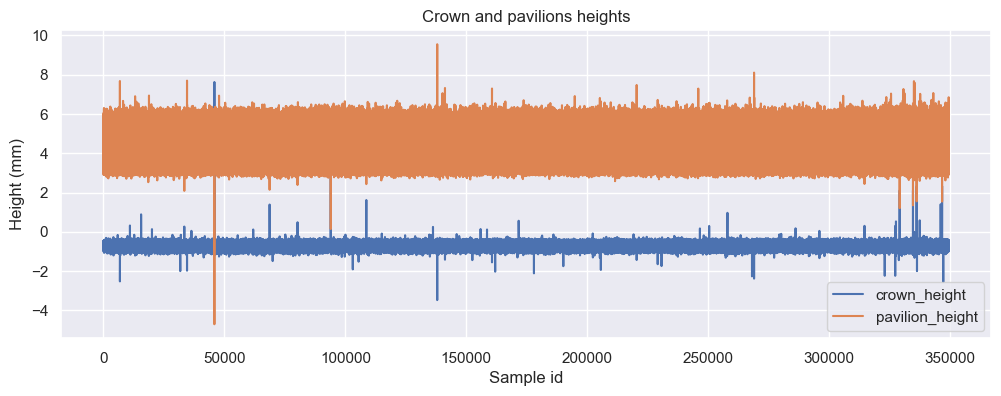

In [17]:
all_data[['crown_height', 'pavilion_height']].plot(figsize=(12, 4))
plt.title('Crown and pavilions heights')
plt.ylabel('Height (mm)')
plt.xlabel('Sample id')
plt.show()

If we are getting negative crown heights, must be due a lower gem volume than expected. Let's use the diamond's density (3.5 $g/cm^3$) instead of the Cubic Zirconia's density.

Source of diamond density: https://en.wikipedia.org/wiki/Diamond

In [18]:
all_data['diamond_volume'] = (all_data['carat']*0.2)/3.5

In [19]:
# Note: 1000 is because we need the volume in cubic millimeters
all_data['crown_height_d'] = (1000*all_data['diamond_volume'] - c1_coef*all_data['new_z'])/(c2_coef - c1_coef)
# Note: hp = z - hc
all_data['pavilion_height_d'] = all_data['new_z'] - all_data['crown_height']

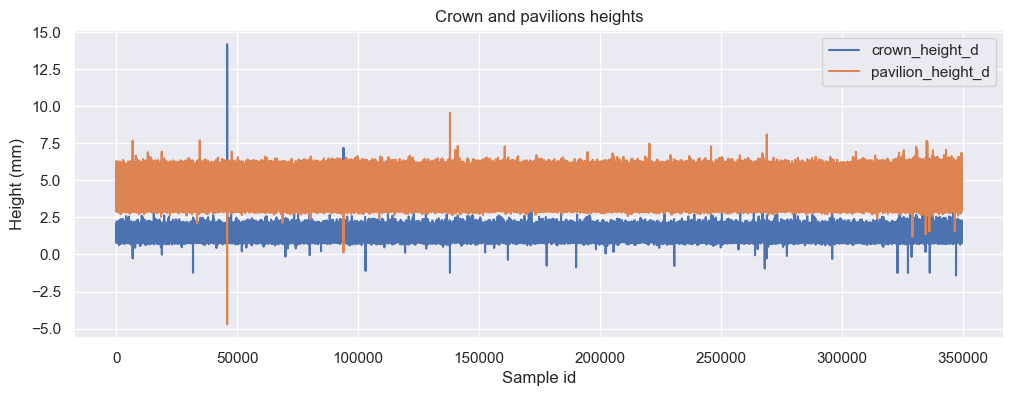

In [20]:
all_data[['crown_height_d', 'pavilion_height_d']].plot(figsize=(12, 4))
plt.title('Crown and pavilions heights')
plt.ylabel('Height (mm)')
plt.xlabel('Sample id')
plt.show()

In this case, we have coherent values, but we sill have some outliers lower than 0. This can be due to the girdle thickess, since we didn't considerated that before but it can be important for these outliers.

# Finding optimal crown, girdle, and pavilion heights

### Volume equations
If we considerate the volume referenced to the girdle, which will be an elliptical cilinder, we have the next three calculous:
$$
\begin{cases}
V_c = \frac{\pi y}{12x} \times \big(x^2 + x x_t + x_t^2 \big) \times h_c \\
V_g = \frac{\pi}{4} \times x \times y \times h_g \\
V_p = \frac{\pi}{12} \times x \times y \times h_p \\
\end{cases}
$$
Where $V_c$, $V_g$, $V_p$, are the volumens of the crown, girdle and pavilion respectively. $h_c$, $h_g$, $h_p$ are the heights of crown, girdle and pavilion respectively. And $x_t$ is the table diameter.

*Note:* all items of $x$, $y$ and $x_t$ were divided by 2 since we are working with radious instead of diameters. 

Reference of elliptic cylinder area: https://keisan.casio.com/exec/system/15380992152819

### Equation sistem
If we include in the equations the girdle height, we can not solve the linear equations generated above, since we have only two equations for three variables ($h_c$, $h_g$, $h_p$)
$$
\begin{cases}
V_{T} = V_{c} + V_{g} + V_{p} \\
z = h_{c} + h_{g} + h_{p} \\
\end{cases}
$$



### Optimization problem
The resolution of the equation system can be approximated by an optimization problem, which we define in this section.

#### New notation
Before starting to resolve the problem, we need to do some changes in the notation of our elements:

Let be $h_{c}'$, $h_{g}'$, and $h_{p}'$ three variables with domain $\in [0, 1]$ and meet the next two conditions
1. $h_{c}' + h_{g}' + h_{p}' = 1$
2. $ h_{c} = z \times h_{c}' \qquad h_{g} = z \times h_{g}' \qquad h_{p} = z \times h_{p}' $

These new vars can be seen as the proportion of our $z$ which is used for our crown, girdle, and pavilion respectively. And if we rewrite the volume formulas using the relationship between $h$ and $h'$, we have:
$$
\begin{cases}
V_c = \frac{\pi y}{12x} \times \big(x^2 + x x_t + x_t^2 \big) \times z \times h_c' = V_c' \times h_c' \\
V_g = \frac{\pi}{4} \times x \times y \times z \times h_g' = V_g' \times h_g' \\
V_p = \frac{\pi}{12} \times x \times y \times z \times h_p' = V_p' \times h_p' \\
\end{cases}
$$

Where $V_c'$, $V_g'$, $V_p'$ are the volume of the elliptical truncated cone (crown), elliptical cilinder (girdle), and the elliptical cone (pavilion) calculated with z instead of $h_{c}$, $h_{g}$, and $h_{p}$

So, we can precompute the volume of each generic element ($V_c'$, $V_g'$, $V_p'$), and then multiply by its respective proportion ($h_c'$, $h_g'$, $h_p'$).

**Note:** from now on, all the references made to $V_c'$, $V_g'$, $V_p'$, $h_c'$, $h_g'$, $h_p'$ will be done by $V_c$, $V_g$, $V_p$, $h_c$, $h_g$, $h_p$ for a simplest notation.

#### Perfect proportions
For proportion references, we include the next picture (The proportions are near perfect, but they aren't due to the table proportion, which is 62% and the perfect range is $[54, 57]$)

![diamond_proportions](https://www.diamonds.pro/wp-content/uploads/2020/10/Proportions.png)

Source: https://www.diamonds.pro/education/triple-excellent-diamond/

In the guide referenced in [[2](https://www.gia.edu/doc/booklet_finish_culet_girdle.pdf)], we obtain the following proportions for a perfect diamond:
+ The perfect depth goes from 59 to 62.6%
+ The perfect crown depth is ~13% of the depth
+ The most valuable fiamons have a girlde of 0mm (they aree extremly rare). But the most comon values are in the range 2 - 3.5% of the depth
+ The perfect pavilion depth is ~45% of the depth


If we recalculate the percentages to get the values referenced by z, we have the following proportions (for depth 60.5):
+ Crown %: ~21.5%
+ Girdle %: ~4%
+ Pavilion %: ~74.5%

References for perfect diamond:
1. https://www.diamonds.pro/guides/diamond-proportion/
2. https://www.gia.edu/doc/booklet_finish_culet_girdle.pdf


#### Function to optimace
Given the proportions above, we need to find the heights of crown, girdle, and pavilion near to them, which means

$$
\begin{cases}
h_c \approx 0.215 \\
h_g \approx 0.04 \\
h_p \approx 0.745 \\
\end{cases}
$$

And also, need to meet the condition
$$ V_t = V_c \times h_c + V_g \times h_g + V_p \times h_p $$

So, we need to minimize the next error
$$ error = \left| V_t - (V_c \times h_c + V_g \times h_g + V_p \times h_p) \right| + |h_c - 0.215| + |h_g - 0.04| + |h_p - 0.745|$$


And meet the following conditions:
$$
\begin{cases}
0 \leq h_{c}, h_{g}, h_{p} \leq 1 \\
h_{c} + h_{g} + h_{p} = 1 \\
h_{g} \leq h_{c} \\
h_{c} \leq h_{p} \\
h_{g} \leq h_{p} \\
\end{cases}
$$


### Optimization functions

In [21]:
# Funtion to optimize
def opt_func(h, vc, vg, vp, vt):
    volume_error = np.abs(vt - (vc*h[0] + vg*h[1] + vp*h[2]))
    best_items_errors = np.mean(np.abs(0.215 - h[0]) + np.abs(0.04 - h[1]) + np.abs(0.745 - h[2]))
    return 0.5*volume_error + 0.5*best_items_errors

# Condition of h in [0, 1]
bounds = [(1e-5, 1)]*3
# Sum equals 1 condition
sum_1_constraint = LinearConstraint(np.ones(3), lb=1, ub=1)
# Three inequalities conditions
inequalities_constraint = LinearConstraint([[1, -1, 0], [-1, 0, 1], [0, -1, 1]], lb=1e-3, ub=np.inf)

# Funtion which runs the optimization problem
def obtain_op_dims(vc, vg, vp, vt):
    res = minimize(
        opt_func,
        x0=[0.2, 0.05, 0.75],
        args=(vc, vg, vp, vt),
        constraints=[sum_1_constraint, inequalities_constraint],
        bounds=bounds,
        options={'maxiter': 50},
    )
    return res

### Precomputed values
**Note:** the diamond volume is used, because previous runs with the volume of the cubic zirconia resulted in optimization errors.

In [22]:
# Total volume
all_data['vt'] = 1000*all_data['diamond_volume']



lx = all_data['new_y']*np.tan(np.pi/8)
ly = all_data['new_x']*np.tan(np.pi/8)
lxt = all_data['table_x']*np.tan(np.pi/8)
lyt = all_data['table_y']*np.tan(np.pi/8)

ag = all_data['new_x']*all_data['new_y'] - (all_data['new_x'] - lx)*(all_data['new_y'] - ly)/2
at = all_data['table_x']*all_data['table_y'] - (all_data['table_x'] - lxt)*(all_data['table_y'] - lyt)/2





all_data['vc'] = ((np.pi*all_data['new_y']*all_data['new_z'])/(12*all_data['new_x']))*\
    (all_data['new_x'].pow(2) + all_data['new_x']*all_data['table_x'] + all_data['table_x'].pow(2))
all_data['vg'] = (np.pi/4)*all_data['new_x']*all_data['new_y']*all_data['new_z']
all_data['vp'] = (np.pi/12)*all_data['new_x']*all_data['new_y']*all_data['new_z']

### Optimization loop

In [23]:
res_list = []
for _, row in tqdm.tqdm_notebook(all_data.iterrows()):
    result = obtain_op_dims(vc=row['vc'], vg=row['vg'], vp=row['vp'], vt=row['vt'])
    res_list.append(result.x)

0it [00:00, ?it/s]

### Adding results to our data

In [27]:
heights_results = pd.DataFrame(res_list, columns=['crown_height_opt', 'girdle_height_opt', 'pavilion_height_opt'])
heights_results.describe()

,crown_height_opt,girdle_height_opt,pavilion_height_opt
count,349590.000000,349590.000000,349590.000000
mean,0.214696,0.071445,0.713859
std,0.003813,0.011696,0.012116
min,0.001010,0.000010,0.334333
25%,0.214997,0.064329,0.707348
50%,0.215000,0.071213,0.714053
75%,0.215001,0.078176,0.720861
max,0.333333,0.332333,0.998980


In [28]:
all_data_plus_heights = pd.concat([all_data, heights_results], axis=1)
all_data_plus_heights.to_parquet('./data/all_data_plus_heights.parquet')

## Crown and pavilion angles

Once we have the crown and pavilion heights, we are able to calculate the angle of the crown and the pavilion using trigonometry formulas.

Given the next gem shape:

![gem_example](https://www.gia.edu/images/163898-636x358.jpg)

Source: https://www.gia.edu/diamond-cut/diamond-cut-anatomy-round-brilliant

The crown and pavilion angles can be calculated as follow:
$$ crownAngle = \arctan \left( \frac{crownHeight}{\frac{girdle Diameter}{2}} \right) \qquad pavilionAngle = \arctan \left( \frac{pavilionHeight}{\frac{girdleDiameter - tableDiameter}{2}} \right)$$


In [33]:
arctan_param = all_data_plus_heights['crown_height_opt']/((all_data_plus_heights['new_x'] - all_data_plus_heights['table_x'])/2)
all_data_plus_heights['crown_angle'] = arctan_param.apply(np.arctan)

arctan_param = all_data_plus_heights['pavilion_height_opt']/(all_data_plus_heights['new_x']/2)
all_data_plus_heights['pavilion_angle'] = arctan_param.apply(np.arctan)

Also, once we know the pavilion angle, we are able to calculate the culet angle as follows
$$ culetAngle = 2\times \left(\frac{\pi}{2} - pavilionAngle \right) $$

In [34]:
all_data_plus_heights['culet_angle'] = 2*(np.pi/2 - all_data_plus_heights['pavilion_angle'])

In [35]:
all_data_plus_heights[['pavilion_angle', 'crown_angle', 'culet_angle']].describe()

,pavilion_angle,crown_angle,culet_angle
count,349590.000000,349590.000000,349590.000000
mean,0.253263,0.180233,2.635067
std,0.047326,0.032976,0.094652
min,0.096191,0.000480,2.257226
25%,0.215408,0.153163,2.549480
50%,0.245249,0.176801,2.651094
75%,0.296056,0.209298,2.710777
max,0.442183,0.436247,2.949211


### Data saving
We generate a parquet file with the new updates.

In [36]:
all_data_plus_heights.to_parquet('./data/all_data_ph_pangles.parquet')